# Model Development

load dataset

In [18]:
import pandas as pd

concrete =pd.read_csv('../data/clean_data.csv')
concrete.head() 

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)",water_cement_ratio
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366,0.300000
1,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847,0.857143
2,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770,0.600000
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291,0.857143
4,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790,0.480000


### `K-fold Cross validations and Randomized Search for hyperparameter tunning`
Data was split into 10 equal parts with 10-folds CV
 * 9 parts are used for training
 * 1 part is used for validation

X = features

y = label (Compressive strength)

In [24]:
concrete.columns = concrete.columns.str.strip()
print(concrete.columns)

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals)',
       'water_cement_ratio'],
      dtype='object')


In [23]:
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np

In [25]:
X = concrete.drop("Concrete compressive strength(MPa, megapascals)", axis=1).values
y = concrete["Concrete compressive strength(MPa, megapascals)"].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [41]:
def randomized_search_all(X_train, y_train, X_test, y_test, n_iter=20, cv_splits=10):
    # models and parameter grids
    models_params ={
        "AdaBoost": (
            AdaBoostRegressor(random_state=100),
            {
                "n_estimators": [50, 100, 200, 300],
                "learning_rate": np.linspace(0.01, 1.0, 10)
            }
        ),
        "Random Forest" :(
            RandomForestRegressor(random_state=100),
            {
                "n_estimators": [100, 200, 300],
                "max_depth" : [5, 10, None],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            }
        ),
        "XGBoost": (
            XGBRegressor(random_state=100, eval_metric='rmse'),
            {
                "n_estimators": [100, 200, 500],
                "learning_rate": [0.01, 0.005, 0.1, 0.3],
                "max_depth": [3, 5, 7, 9],
                "subsample": [0.6, 0.8, 1.0],
                "colsample_bytree": [0.6, 0.8, 1.0]
            }
        ),
        "LightGMB": (
            LGBMRegressor(random_state=100 ),
            {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.05, 0.1],
                "num_leaves": [20, 30, 40]
            }
        ),
        "CatBost": (
            CatBoostRegressor(random_state=100, verbose=0),
            {
                "iterations": [200, 500, 800],
                "learning_rate": [0.01, 0.05, 0.1],
                "depth": [4, 6, 8, 10]
            }
        )
    }
    results ={}
    kfold = KFold(n_splits=cv_splits, shuffle = True, random_state=100)

    for name, (model, param_dist) in models_params.items():
        print(f"\nRunning RandomizedSearchCV for {name}...")

        random_search = RandomizedSearchCV(
            estimator = model,
            param_distributions = param_dist,
            n_iter = n_iter,
            scoring = 'r2',
            cv=kfold,
            verbose = 1,
            n_jobs = -1,
            random_state=100
        )
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)

        results[name] = {
            "best_params": random_search.best_params_,
            "cv_r2": random_search.best_score_,
            "test_r2": r2_score(y_test, y_pred),
            "test_rmse": MSE(y_test, y_pred)**(1/2),
            "best_model": best_model
        }
        print(f"{name} done! Best R2 CV: {random_search.best_score_:.4f}, Test R2: {results[name]['test_r2']:.4f}")

    return results

In [33]:
randomized_search_all(X_train, y_train, X_test, y_test)


Running RandomizedSearchCV for AdaBoost...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
AdaBoost done! Best R2 CV: 0.7845, Test R2: 0.8103

Running RandomizedSearchCV for XGBoost...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
XGBoost done! Best R2 CV: 0.9138, Test R2: 0.9580

Running RandomizedSearchCV for LightGMB...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 728, number of used features: 9
[LightGBM] [Info] Start training from score 33.945960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGMB done! Best R2 CV: 0.9159, Test R2: 0.9555

Running RandomizedSearchCV for CatBost...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
CatBost done! Best R2 CV: 0.9201, Test R2: 0.9564


{'AdaBoost': {'best_params': {'n_estimators': 100,
   'learning_rate': np.float64(0.56)},
  'cv_r2': np.float64(0.7845439655952058),
  'test_r2': 0.8102866318564816,
  'test_rmse': 7.005672758802734,
  'best_model': AdaBoostRegressor(learning_rate=np.float64(0.56), n_estimators=100,
                    random_state=100)},
 'XGBoost': {'best_params': {'subsample': 0.6,
   'n_estimators': 200,
   'max_depth': 5,
   'learning_rate': 0.1,
   'colsample_bytree': 0.6},
  'cv_r2': np.float64(0.9138055554073601),
  'test_r2': 0.9579823370210319,
  'test_rmse': 3.2969839014424287,
  'best_model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.6, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='rmse', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constrai

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_actual_vs_pred(y_test, y_pred, model_name="Model", boundary=10):
    r2 = r2_score(y_test, y_pred)
    rmse = np.mean(MSE(y_test, y_pred))

    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor='k')

    # 45 degree reference line
    max_val = max(max(y_test), max(y_pred))
    min_val = min(min(y_test), min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label= 'Perfect Prediction')

    plt.plot([min(y_train), max(y_train)], [min(y_train) + boundary, max(y_train) + boundary],
     color='green', linestyle=":", label = f'+{boundary} boundary')
    
    plt.plot([min(y_train), max(y_train)], [min(y_train) - boundary, max(y_train) - boundary],
     color='green', linestyle=":", label = f'-{boundary} boundary')
    

    plt.xlabel("Actual Compressive Strength (Mpa)")
    plt.ylabel("Predicted Compressive Strength (Mpa)")
    plt.title(f"Actual vs Predicted ({model_name})")

    plt.text(min(y_test), max(y_pred)*0.9, f'r2 ={r2:.3f}\nRMSE= {rmse:.3f}', fontsize=10, bbox=dict(facecolor= 'white', alpha=0.7))
    
    plt.legend()
    plt.grid(True)

    plt.show()

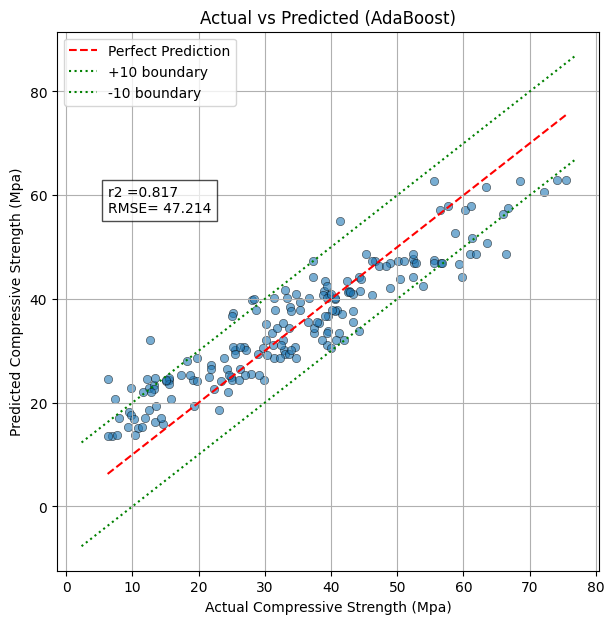

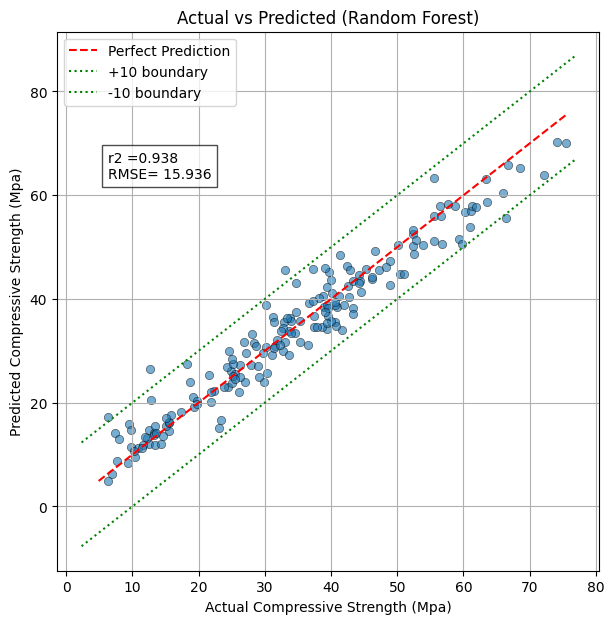

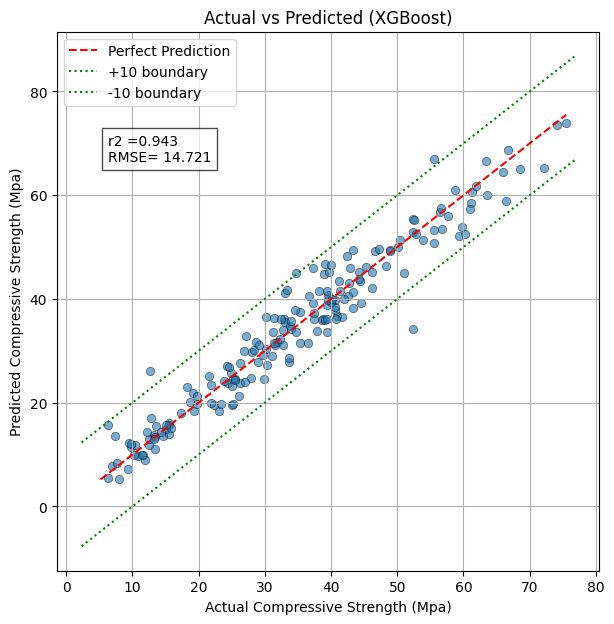

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 728, number of used features: 9
[LightGBM] [Info] Start training from score 33.945960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Danhaya\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


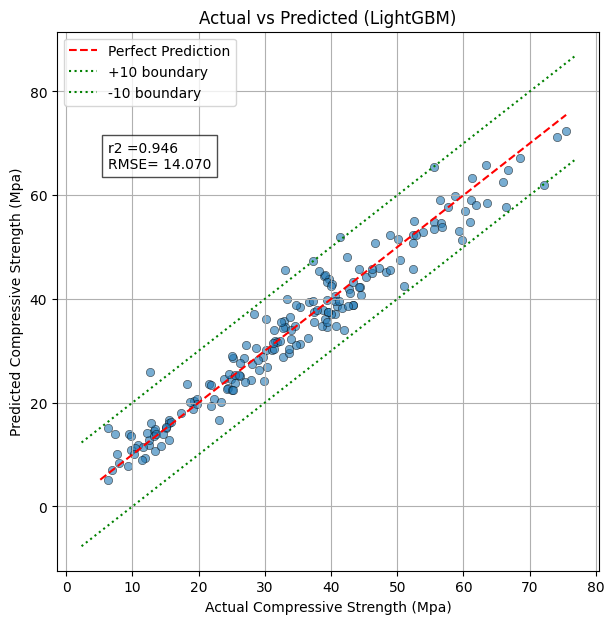

Learning rate set to 0.03894
0:	learn: 15.3945672	total: 19.9ms	remaining: 19.9s
1:	learn: 15.0427253	total: 45.6ms	remaining: 22.7s
2:	learn: 14.7473714	total: 67.7ms	remaining: 22.5s
3:	learn: 14.4487414	total: 106ms	remaining: 26.3s
4:	learn: 14.1171528	total: 113ms	remaining: 22.5s
5:	learn: 13.8091475	total: 133ms	remaining: 22s
6:	learn: 13.4916785	total: 156ms	remaining: 22.2s
7:	learn: 13.2146849	total: 162ms	remaining: 20.1s
8:	learn: 12.9678619	total: 166ms	remaining: 18.2s
9:	learn: 12.7249442	total: 172ms	remaining: 17.1s
10:	learn: 12.4366383	total: 176ms	remaining: 15.8s
11:	learn: 12.1779878	total: 180ms	remaining: 14.8s
12:	learn: 11.9385164	total: 190ms	remaining: 14.5s
13:	learn: 11.7099841	total: 222ms	remaining: 15.6s
14:	learn: 11.4736865	total: 292ms	remaining: 19.2s
15:	learn: 11.2374521	total: 301ms	remaining: 18.5s
16:	learn: 11.0124576	total: 314ms	remaining: 18.2s
17:	learn: 10.7957708	total: 319ms	remaining: 17.4s
18:	learn: 10.6102450	total: 323ms	remaining

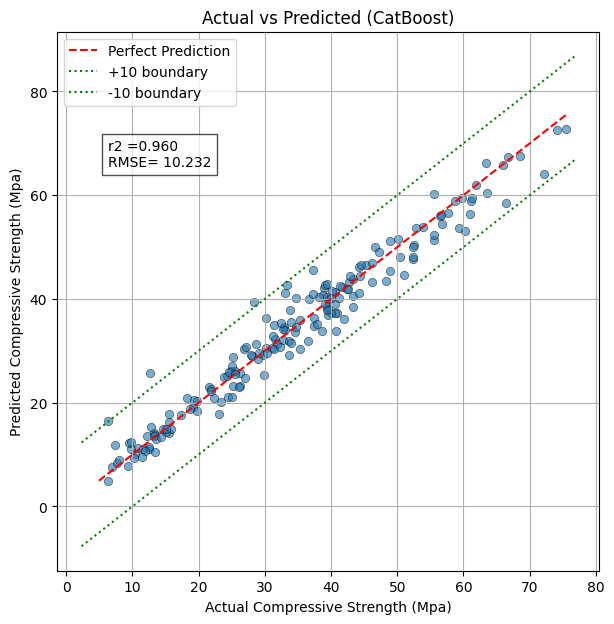

In [45]:
adaboost, rf, xgboost, lightgbm, catboost = AdaBoostRegressor(), RandomForestRegressor(), XGBRegressor(), LGBMRegressor(), CatBoostRegressor()

models = [adaboost, rf, xgboost, lightgbm, catboost]
model_names = ["AdaBoost", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_actual_vs_pred(y_test, y_pred, model_name= name)
